In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Big_Data_Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


spark

In [2]:
# Pyspark Libraries
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql import types as T
from pyspark.sql.types import StructField,IntegerType, StructType,StringType
from pyspark.ml.feature import StringIndexer, Imputer


#Other Libraries
import numpy as np
import pandas as pd # for creating dataframes
import matplotlib.pyplot as plt #Basic Plotting
%matplotlib inline
import seaborn as sns #Prettier Plot
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [7]:
df = spark.read.csv('C:/Users/Prateek/Documents/docker/loan.csv', header = True, inferSchema = True)

df.count()

2260668

In [8]:
df = df.drop('debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint',
       'hardship_amount', 'hardship_dpd', 'hardship_end_date',
       'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'id', 'il_util', 'inq_fi', 'inq_last_12m',
       'max_bal_bc', 'member_id', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_rcnt_il', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m',
       'open_rv_24m', 'orig_projected_additional_accrued_interest',
       'payment_plan_start_date', 'revol_bal_joint',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line',
       'sec_app_inq_last_6mths', 'sec_app_mort_acc',
       'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts',
       'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
       'settlement_amount', 'settlement_date', 'settlement_percentage',
       'settlement_status', 'settlement_term', 'title', 'total_bal_il',
       'total_cu_tl', 'total_rev_hi_lim', 'url',
       'verification_status_joint', 'id', 'member_id', 'zip_code')

In [9]:
#check columns for missing values
# we drop columns with more than 30% missing values since imputing them could introduce bias in data
droplist = []
count = df.count()
for col in df.columns:
    cnt = df.filter(df[col].isNull()).count()
    null_per = (cnt/count)*100
    print(col, " ", "with null values: ", cnt)
    print(col, " ", "with % null values: ", null_per, '%')
    if null_per > 30:
        droplist.append(col)

loan_amnt   with null values:  0
loan_amnt   with % null values:  0.0 %
funded_amnt   with null values:  0
funded_amnt   with % null values:  0.0 %
funded_amnt_inv   with null values:  0
funded_amnt_inv   with % null values:  0.0 %
term   with null values:  0
term   with % null values:  0.0 %
int_rate   with null values:  0
int_rate   with % null values:  0.0 %
installment   with null values:  0
installment   with % null values:  0.0 %
grade   with null values:  0
grade   with % null values:  0.0 %
sub_grade   with null values:  0
sub_grade   with % null values:  0.0 %
emp_title   with null values:  166931
emp_title   with % null values:  7.384144863376665 %
emp_length   with null values:  0
emp_length   with % null values:  0.0 %
home_ownership   with null values:  0
home_ownership   with % null values:  0.0 %
annual_inc   with null values:  4
annual_inc   with % null values:  0.00017693885170224022 %
verification_status   with null values:  0
verification_status   with % null values:

debt_settlement_flag   with null values:  193
debt_settlement_flag   with % null values:  0.008537299594633091 %


In [10]:
droplist

['annual_inc_joint', 'all_util']

In [14]:
red_df = df.drop(*droplist).na.drop()

In [15]:
red_df.count()

1669113

In [16]:
red_df.dtypes

[('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'double'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('loan_status', 'string'),
 ('pymnt_plan', 'string'),
 ('purpose', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'string'),
 ('earliest_cr_line', 'string'),
 ('inq_last_6mths', 'string'),
 ('open_acc', 'string'),
 ('pub_rec', 'string'),
 ('revol_bal', 'string'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'string'),
 ('out_prncp_inv', 'string'),
 ('total_pymnt', 'string'),
 ('total_pymnt_inv', 'string'),
 ('total_rec_prncp', 'string'),
 ('total_rec_int', 'string'),
 ('total_rec_late_fee', 'string'),
 ('recoveries', 'string'),
 ('co

We emphasis on the following:
- The ratio of defaulters
- The reason for getting the loan issued
- The interest rate on issues loans

In [12]:
a4dims = (11.7, 8.27)

Defaulters(our labels)

In [17]:
red_df.groupBy(['loan_status']).count().orderBy('count', ascending = False).show(10,  truncate = False)

+------------------+------+
|loan_status       |count |
+------------------+------+
|Fully Paid        |772878|
|Current           |676833|
|Charged Off       |193654|
|Late (31-120 days)|16195 |
|In Grace Period   |6850  |
|Late (16-30 days) |2678  |
|Default           |25    |
+------------------+------+



In [18]:
data = red_df.withColumn("default", 
   F.when((red_df.loan_status == 'Fully Paid') | (red_df.loan_status == 'Current') | \
          (red_df.loan_status == 'Does not meet the credit policy. Status:Fully Paid') ,0).otherwise('1'))

data = data.drop('loan_status')

data.groupBy(['default']).count().orderBy('count', ascending = False).show(10,  truncate = False)

+-------+-------+
|default|count  |
+-------+-------+
|0      |1449711|
|1      |219402 |
+-------+-------+



Text(0, 0.5, 'Number of Customers')

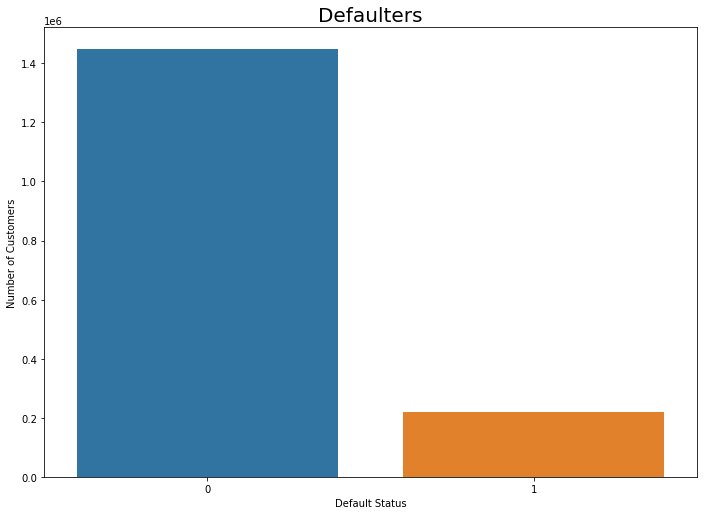

In [22]:
defaulters = data.select('default', 'int_rate', 'term').toPandas()

fig, ax = plt.subplots(figsize = a4dims)

sns.countplot(x = 'default', data = defaulters)
ax.set_title('Defaulters', fontsize = 20)
ax.set_xlabel('Default Status')
ax.set_ylabel('Number of Customers')

Text(0, 0.5, 'Number of Customers')

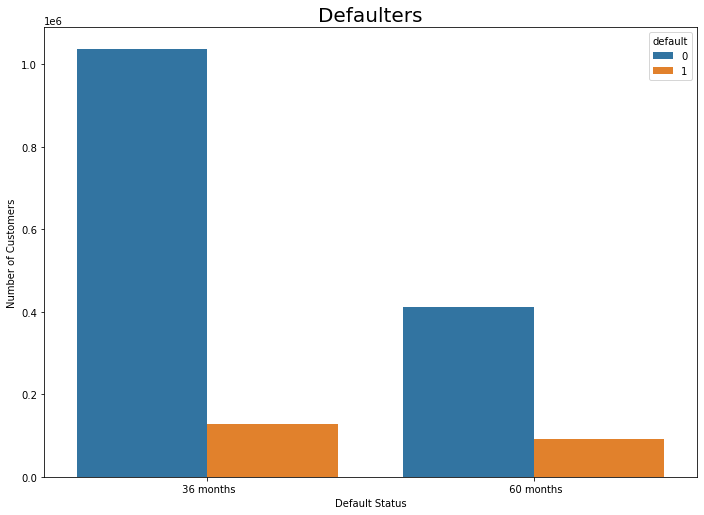

In [24]:
fig, ax = plt.subplots(figsize = a4dims)

sns.countplot(x = 'term',hue ='default', data = defaulters)
ax.set_title('Defaulters', fontsize = 20)
ax.set_xlabel('Default Status')
ax.set_ylabel('Number of Customers')

The number of loan defaults are higher on 60 months loan term with respect to number of loans issued.

Text(0, 0.5, 'Interest Rates')

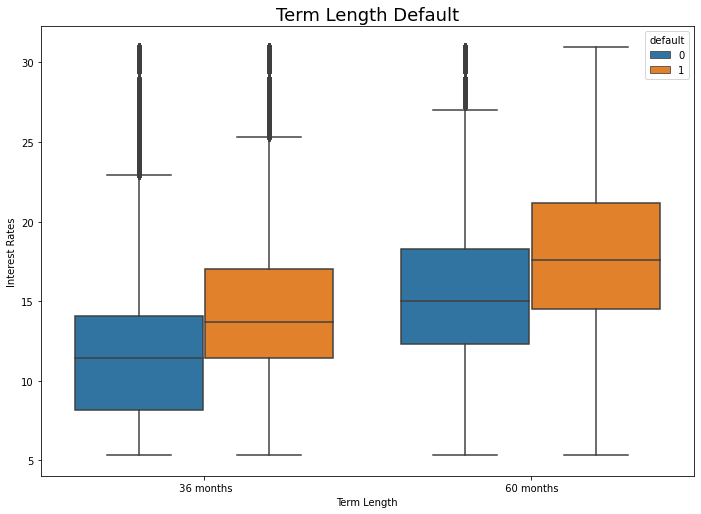

In [23]:
fig, ax = plt.subplots(figsize = a4dims)
sns.boxplot(x= 'term', y= 'int_rate', hue='default', data= defaulters)
ax.set_title('Term Length Default', fontsize = 18)
ax.set_xlabel('Term Length')
ax.set_ylabel('Interest Rates')

Reasons for taking out loan